In [ ]:
# explore brain prediction results

In [1]:
import h5py
import torch
import csv
import PIL.Image
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat


In [ ]:
# paths

root_path = 'Z:/CNAI2/Mansoure_NSD/'
output_path = root_path + 'output/'
exp_path = root_path + 'experiments/'
score_path = root_path + 'phase1/output/'


In [10]:
#load all subjects data 

nsubject = 8

pred_act = np.zeros((1000,24))
pred_acc = np.zeros((1,24))

for subject in range(1,nsubject+1):
    sub_pred_act = np.load(output_path+f'subj{subject:02d}/act_pred.npy')
    sub_pred_acc = np.load(output_path+f'subj{subject:02d}/acc.npy')

    pred_act = pred_act + sub_pred_act
    pred_acc = pred_acc + sub_pred_acc

pred_act = pred_act/nsubject
pred_acc = pred_acc/nsubject

print('predicted act shape', pred_act.shape)

predicted act shape (1000, 24)


Text(0, 0.5, 'Accuracy')

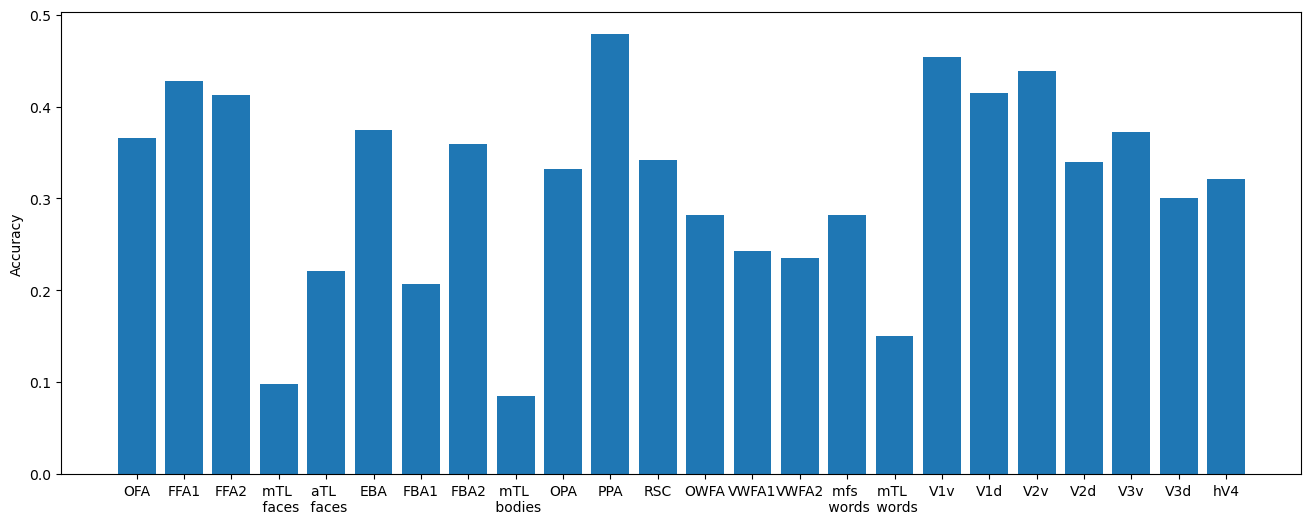

In [19]:
# calculate average model accuracy

ROIs = ['OFA', 'FFA1', 'FFA2', 'mTL \n faces', 'aTL \n faces', 'EBA', 'FBA1', 'FBA2', 'mTL \n bodies', 'OPA', 
        'PPA', 'RSC', 'OWFA', 'VWFA1', 'VWFA2', 'mfs \n words', 'mTL \n words', 'V1v', 'V1d', 'V2v', 
        'V2d', 'V3v', 'V3d', 'hV4']

plt.figure(figsize=(16,6))
plt.bar(ROIs,pred_acc[0,:])
plt.ylabel('Accuracy')


Text(0.5, 1.0, 'average predcited activations across subjects in different ROIs')

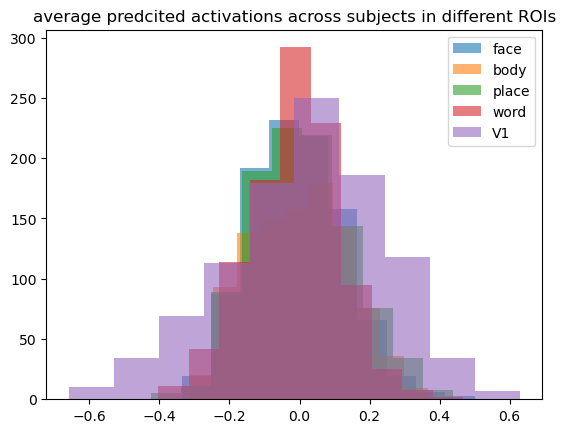

In [3]:

# face roi
roi_id = 0
plt.hist(pred_act[:,roi_id], alpha=0.6, label='face', )

# body roi
roi_id = 5
plt.hist(pred_act[:,roi_id], alpha=0.6, label='body')

#place
roi_id = 9
plt.hist(pred_act[:,roi_id], alpha=0.6, label='place')

#word
roi_id = 12
plt.hist(pred_act[:,roi_id], alpha=0.6, label='word')

# early visual
roi_id = 17
plt.hist(pred_act[:,roi_id], alpha=0.6, label='V1')

plt.legend()
plt.title('average predcited activations across subjects in different ROIs')

In [4]:
# load images id
exp_design = loadmat(exp_path+'nsd_expdesign.mat')
shared_id = exp_design['sharedix']

# load scores
pred_score = pd.DataFrame({
    'image id': shared_id[0],
    'score':pd.read_csv(score_path+'memorability_scores.csv', sep=',', header=None).squeeze(),
})

# sort score
sorted_ind = pred_score.sort_values('score', ascending=False).index
sorted_ind


Index([932, 747, 939, 799, 605, 487, 929, 274, 157, 214,
       ...
       352, 956, 455, 486, 132, 590, 895, 572, 149, 701],
      dtype='int64', length=1000)

Significant: [False False False  True  True False  True False  True  True  True  True
 False  True  True  True  True False False False False False  True False]


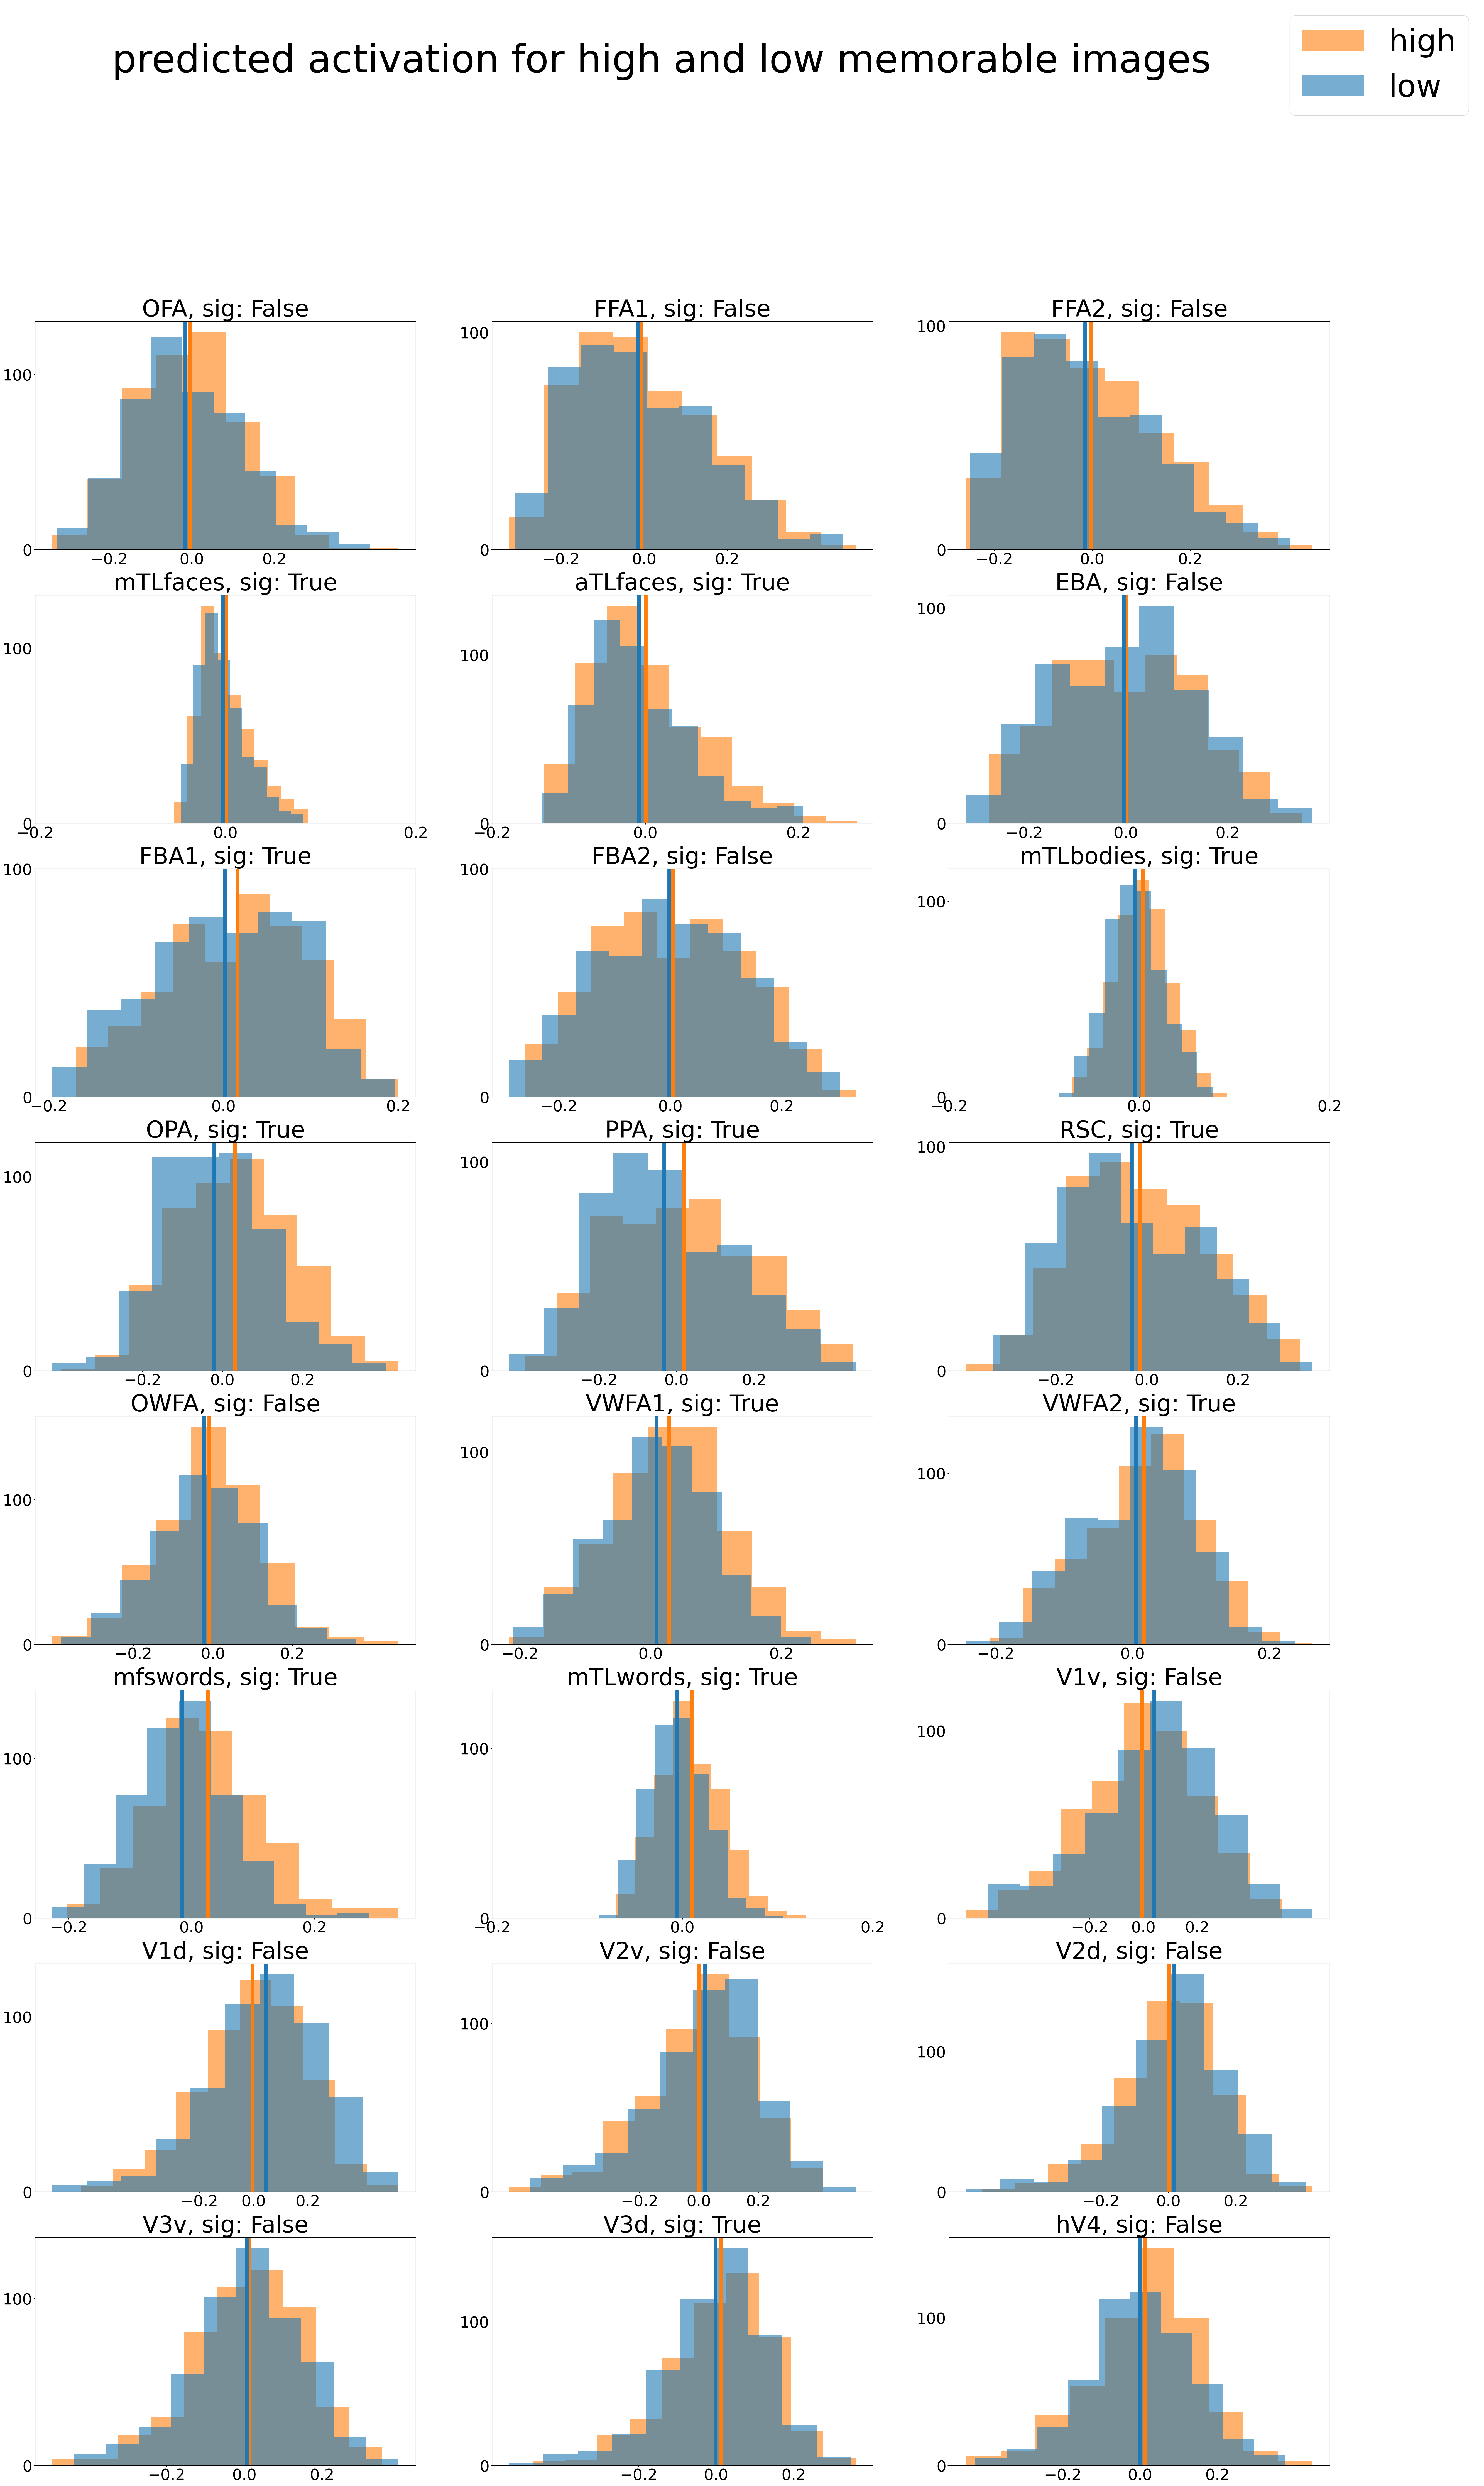

In [5]:
# plot histogram of high memorable and low memorable images
nim = 500
orange = '#ff7f0e'
blue = '#1f77b4'

plt.figure(figsize=(60,100))
plt.suptitle('predicted activation for high and low memorable images',fontsize = 100)
roi_id = 0
pvalue = np.zeros(len(ROIs))

for i in range(8):
    for j in range(3):   
        ax0 = plt.subplot2grid((8,3), (i,j))
        # predicted activation for high and low memorable images
        high = pred_act[sorted_ind[0:nim],roi_id]
        low = pred_act[sorted_ind[-nim::],roi_id]

        # ttest
        (_, pvalue[roi_id]) = sp.stats.ttest_ind(high, low, alternative='greater')

        # plot histogram
        plt.hist(high, alpha=0.6, label='high', color = orange)
        plt.hist(low, alpha=0.6, label='low', color = blue)

        plt.axvline(pred_act[sorted_ind[0:nim],roi_id].mean(), color=orange, label='mean', linewidth=10)
        plt.axvline(pred_act[sorted_ind[-nim::],roi_id].mean(), color=blue, label='mean', linewidth=10)
        plt.title(ROIs[roi_id]+', sig: '+str(pvalue[roi_id]<0.05), fontsize = 60)
        roi_id+=1

        plt.xticks([-0.2,0, 0.2], fontsize=40)
        plt.yticks([0, 100], fontsize=40)
        

plt.figlegend(['high', 'low'], fontsize = 80)

print('Significant:', pvalue<0.05)

In [8]:
pvalue

array([9.93808103e-02, 2.08917936e-01, 1.03207723e-01, 9.91978775e-03,
       1.93134227e-02, 2.63221531e-01, 3.06067751e-03, 2.15166261e-01,
       7.90886699e-07, 4.27794011e-09, 2.78719768e-06, 2.44688846e-02,
       5.05812231e-02, 2.13028650e-04, 1.26203666e-02, 6.88734741e-15,
       7.51925057e-14, 9.99311070e-01, 9.99904299e-01, 9.66381349e-01,
       9.54349692e-01, 2.63861158e-01, 3.90717065e-02, 6.31095346e-02])

In [31]:
# check correlation between predicted activations and predicted scores
c=np.zeros(len(ROIs))
p=np.zeros(len(ROIs))
for i in range(len(ROIs)):
    (c[i],p[i]) = sp.stats.pearsonr(pred_act[:,i],np.array(pred_score['score']))

print('correlation:', c)
print('p value:', p<0.05)

correlation: [ 0.05102906  0.00864806  0.02497586  0.06494618  0.05491565 -0.01142729
  0.08942911  0.00239905  0.14441633  0.21521939  0.16665497  0.06544989
  0.07575643  0.14111857  0.08479797  0.29727811  0.26744618 -0.12225074
 -0.13181459 -0.06680001 -0.0598812   0.03433147  0.07249569  0.07729918]
p value: [False False False  True False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True False False  True  True]
